In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# Generate a synthetic dataset
X, y = make_classification(n_samples=500, n_features=10, n_informative=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """Build the tree based on training data."""
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        """Predict the class of each sample."""
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth):
        """Recursive function to build the tree."""
        n_samples, n_features = X.shape
        unique_labels = np.unique(y)

        # Stop criteria
        if len(unique_labels) == 1:
            return {"label": unique_labels[0]}
        if self.max_depth is not None and depth >= self.max_depth:
            return {"label": self._most_common_label(y)}

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return {"label": self._most_common_label(y)}

        # Split data
        left_idxs = X[:, best_feature] <= best_threshold
        right_idxs = X[:, best_feature] > best_threshold

        # Recursively build left and right branches
        left_subtree = self._build_tree(X[left_idxs], y[left_idxs], depth + 1)
        right_subtree = self._build_tree(X[right_idxs], y[right_idxs], depth + 1)

        return {
            "feature": best_feature,
            "threshold": best_threshold,
            "left": left_subtree,
            "right": right_subtree,
        }

    def _best_split(self, X, y):
        """Find the best feature and threshold for splitting."""
        n_samples, n_features = X.shape
        best_gain = -1
        split_idx, split_thresh = None, None

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature_idx], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, feature, y, threshold):
        """Calculate the information gain of a split."""
        parent_entropy = self._entropy(y)

        left_idxs = feature <= threshold
        right_idxs = feature > threshold

        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
            return 0

        n = len(y)
        n_left, n_right = np.sum(left_idxs), np.sum(right_idxs)

        left_entropy = self._entropy(y[left_idxs])
        right_entropy = self._entropy(y[right_idxs])

        child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy

        return parent_entropy - child_entropy

    def _entropy(self, y):
        """Calculate entropy of labels."""
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        """Find the most common label in a set of labels."""
        return np.bincount(y).argmax()

    def _traverse_tree(self, x, node):
        """Traverse the tree for prediction."""
        if "label" in node:
            return node["label"]

        if x[node["feature"]] <= node["threshold"]:
            return self._traverse_tree(x, node["left"])
        else:
            return self._traverse_tree(x, node["right"])


In [4]:
# Train the decision tree
tree = DecisionTree(max_depth=3)
tree.fit(X_train, y_train)

# Predict on the test set
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.84

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.96      0.86        50
           1       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100



In [5]:
# Select two features for visualization
X_viz = X[:, :2]
X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(X_viz, y, test_size=0.2, random_state=42)

tree_viz = DecisionTree(max_depth=3)
tree_viz.fit(X_train_viz, y_train_viz)

# Decision boundary
x_min, x_max = X_viz[:, 0].min() - 1, X_viz[:, 0].max() + 1
y_min, y_max = X_viz[:, 1].min() - 1, X_viz[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = tree_viz.predict(grid)
Z = Z.reshape(xx.shape)

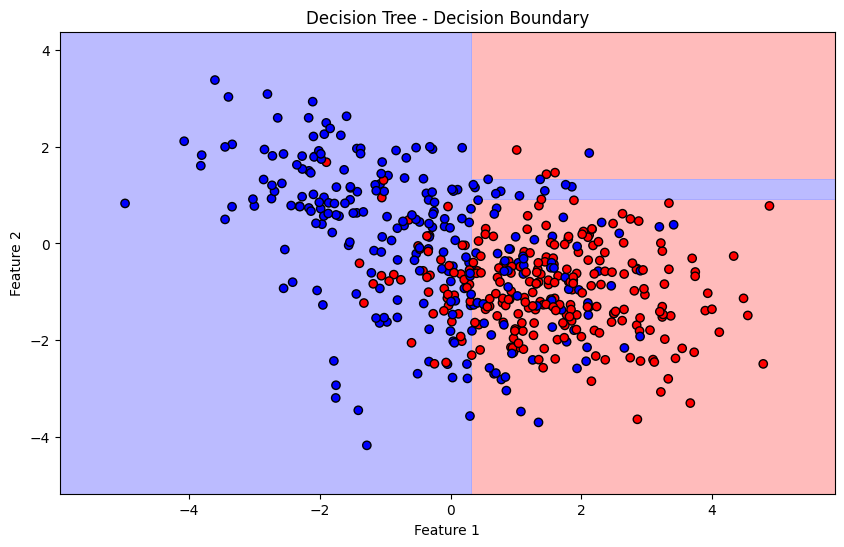

In [6]:
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
plt.scatter(X_viz[:, 0], X_viz[:, 1], c=y, edgecolors='k', cmap=ListedColormap(['#FF0000', '#0000FF']))
plt.title("Decision Tree - Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()